In [ ]:
import sys
sys.path.append('../..')
from lcs import SRC_ROOT

In [1]:
%matplotlib widget
import os
os.environ['ENABLE_PJRT_COMPATIBILITY'] = '1'
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax

In [2]:
from lcs.shi22.shi22 import k_trajectory
from lcs import *
from lcs.configs import *
import jax.numpy as jnp
from lcs.mechanism import *
import matplotlib.pyplot as plt
from lcs.init_mpl import *
from lcs import TEXTWIDTH, PAGEHEIGHT
import numpy as np
from lcs.plotting_utils import *
from lcs.curricula import get_n_phasic_curriculum
from matplotlib.patches import Ellipse
from lcs.joint_learning import run_config
from lcs.configs import Config
from lcs.plotting_utils import make_cosyne_fig

Y_tgts_flip = jnp.eye(2)[::-1]  # for 2d case
g = 100


[WARNING] [2024-11-21 09:47:34,857] in jax._src.xla_bridge: Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



W0000 00:00:1732182454.857954 18845623 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1732182454.878289 18845623 service.cc:145] XLA service 0x1555cc3d0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732182454.878301 18845623 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1732182454.879932 18845623 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1732182454.879950 18845623 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


In [3]:
Y_tgt = get_n_phasic_curriculum(g, cfg_toy_['block_duration'], *Y_tgts_flip)
cfg = Config(**dict(cfg_toy_,
            Y_tgt=Y_tgt, 
            W_teachers=Y_tgts.reshape(2, 2, 1),
            t_tot=1.,
            c_tau=.2 / 3,  # check if change is needed from base cfg
            W_tau=.4 / 3,
            ))

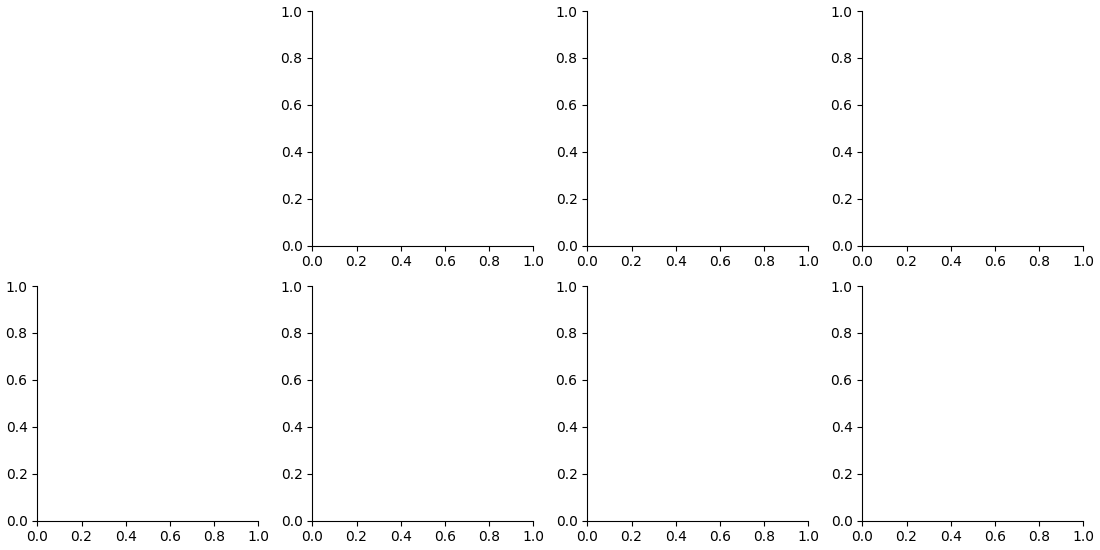

In [4]:
cmap_w = lambda x: plt.get_cmap('Grays')(0.7 + 0.3*x)
cmap_y = lambda x: plt.get_cmap('Grays')(0.7 + 0.3*x)

sc = 2
fig = plt.figure(figsize=(sc*TEXTWIDTH, sc*PAGEHEIGHT*0.25), layout='constrained')
fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72,)

axd = fig.subplot_mosaic("""
ABCD
HEFG
""", 
width_ratios=[1, 1, 1, 1]
                         )
for ax in axd.values():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

axd['A'].axis('off')
ax_y = axd['A']
ax_forget = axd['B']
ax_flexible = axd['C']

ax_grad = axd['D']
ax_block_duration = axd['E']
ax_limcycle = axd['F']
ax_convergence = axd['G']
ax_symmetric = axd['H']

# preview the fig here
plt.show()

In [5]:
lbl_naive = 'forgetful'
largs_naive = dict(ls='--')
lbl_spec = 'flexible'
largs_spec = dict(ls='-')

ms = plt.rcParams['lines.markersize'] / 1.5

alpha_min = 0.5


In [6]:
# SIMULATION
wbar_ini = .1 / 2
tape_forget = get_tape_2d(
    cfg,
    dict(
        w11=1,
        w12=0.,
        w21=1,
        w22=0.,
        c1=.5,
        c2=.5,
    ),
    full2toy=full2toy_6d,
    toy2full=toy2full_6d,
)

tape_flex = get_tape_2d(
    cfg,
    dict(
        w11=1.0,
        w12=0.0,
        w21=0.0,
        w22=1.0,
        c1=1.0,
        c2=0.0,
    ),
    full2toy=full2toy_6d,
    toy2full=toy2full_6d,
)

[INFO] [2024-11-21 09:47:35,917] in lcs.joint_learning: Running 1 seeds on device TFRT_CPU_0 with config Config(input_size=1,
       output_size=2,
       num_seeds=1,
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.1,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='toy',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 10.0),
                            ('L2_W', 0.0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum='A_B__',
       Y_tgt=<function get_n_phasic_curriculum.<locals>.Y_tgt at 0x1653772e0>,
       W_teachers=Array([[[1],
        [0]],

       [[0],
        [1]]], dtype=int32),
       use_X=False,
       metric='cosine,cols',
       teacher_mode='orthogonal',
       teacher_xx=0.0,
       teacher_scale=

/Users/jan/learning-context-sensing/.venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:6217: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/Users/jan/learning-context-sensing/.venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:6218: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/Users/jan/learning-context-sensing/.venv/lib/python3.10/site-packages/jax/_src/nump

[INFO] [2024-11-21 09:47:36,694] in lcs.joint_learning: Running 1 seeds on device TFRT_CPU_0 with config Config(input_size=1,
       output_size=2,
       num_seeds=1,
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.1,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='toy',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 10.0),
                            ('L2_W', 0.0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum='A_B__',
       Y_tgt=<function get_n_phasic_curriculum.<locals>.Y_tgt at 0x1653772e0>,
       W_teachers=Array([[[1],
        [0]],

       [[0],
        [1]]], dtype=int32),
       use_X=False,
       metric='cosine,cols',
       teacher_mode='orthogonal',
       teacher_xx=0.0,
       teacher_scale=

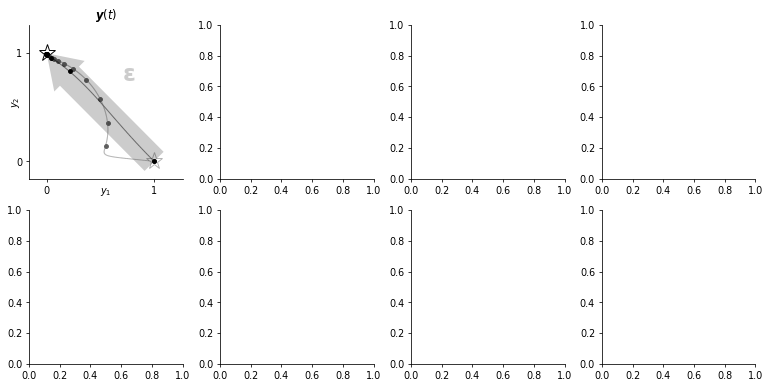

In [7]:
ax = ax_y
ax.cla()
# fig.set_layout_engine('none')

c_y = "black"

ax.set_title(r"$\boldsymbol{y}(t)$")
margs = dict(mark=10, alpha_min=alpha_min, alpha_max=1., ms=ms)


tape = tape_flex
s=1
plot_traj(ax, tape.y[::s][:][..., 0], tape.y[::s][:][..., 1], color=cmap_y(1.), ls="-", **margs)

tape = tape_forget
plot_traj(ax, tape.y[::s][:][..., 0], tape.y[::s][:][..., 1], color=cmap_y(0.), ls="--", **margs, zorder=-10)


# markers
ax.plot(Y_tgts_flip[0, ..., 0], Y_tgts_flip[0, ..., 1], marker='*', markersize=plt.rcParams['lines.markersize'] * 3, mec='black', mfc='none', ls="none",)
ax.plot(Y_tgts_flip[1, ..., 0], Y_tgts_flip[1, ..., 1], marker='*', markersize=plt.rcParams['lines.markersize'] * 3, mec='black', mfc='none', ls="none", alpha=.3)

ax.set_xlabel(r"$y_1$")
ax.set_ylabel(r"$y_2$")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))

# FAT ARROW
ax.arrow(1, 0, -1, 1, head_width=0.4, head_length=0.3, width=1/4, fc=c_y, ec='none', alpha=0.2, length_includes_head=True)
ax.text(0.7, 0.7, r"$\boldsymbol{\varepsilon}$", horizontalalignment='left', verticalalignment='bottom', fontsize=12*2, color=c_y, alpha=0.2)

ax.dataLim.y1 = 1.2
ax.dataLim.y0 = -0.1
ax.dataLim.x1 = 1.2
ax.dataLim.x0 = -0.1
xylabel_to_ticks(ax)
ax.autoscale_view()

fig

In [8]:
ax = ax_grad
ax.cla()
ax.set_title(r"$\nabla_c \mathcal{L} = \boldsymbol{w}^{pT} \boldsymbol{\varepsilon}$")

@np.vectorize(signature="(),(),(i)->()")
def fn(w1, w2, eps):
    w = jnp.array([w1, w2])
    w_eps = w @ eps
    return w_eps

w1 = np.linspace(-.5, 1.5, 100)
w2 = np.linspace(-.5, 1.5, 100)
W1, W2 = np.meshgrid(w1, w2)

eps = np.array([-1., 1.])

with no_autoscale(ax):
    ax.contour(W1, W2, (fn(W1, W2, eps)), levels=20, colors='black', linewidths=0.5)
    m = ax.pcolormesh(W1, W2, (fn(W1, W2, eps)), shading="gouraud", cmap=cmap_div, alpha=0.5, vmin=-1.5, rasterized=True, vmax=1.5)

fig.colorbar(m, ax=ax, )
ax.set_xlabel(r'$w^p_1$')
ax.set_ylabel(r'$w^p_2$')
ax.use_sticky_edges = False

In [9]:
# FLEXIBLE AND FORGETFUL
s = 100  # stride
maxp = slice(0, None)

ax = ax_flexible
ax.cla()
ax.set_title(r"flexible")

# ax.set_title(r"$d\boldsymbol{w}^p(n\,dt)$")

offset__flex_forg = .0
offset_path = .06

margs = dict(alpha_min=1., alpha_max=1., lw=3, mark='none', ms=ms)

from matplotlib.colors import LinearSegmentedColormap
from lcs.plotting_utils import c_line, add_arrow_to_line2D

# Define the colors with stops
# : (position, (R, G, B, Alpha))
colors = [(0.0, (0, 0, 0, 0.0)),   # Black
          (0.5, (0, 0, 0, 0.0)), # Black
          (1.0, (0, 0, 0, 0.3))]    # Black

# Create the colormap
cmap_grays_alpha = LinearSegmentedColormap.from_list("cmap_grays_alpha", colors)
arrow_locs = [.333, .666]
lw_cline = 10


tape = tape_flex
# tiny inset in upper right

axi = ax.inset_axes([0.7, 0.7, 0.3, 0.3])
axi.plot(tape.t[::s][maxp], tape.loss[::s][maxp], color='black', ls="-", alpha=1., lw=1, marker='none', ms=2)
axi.dataLim.y0 = 0
axi.dataLim.y1 = 1
axi.set_ylabel(r'$\mathcal{L}$')
axi.set_xlabel(r'$t$')
axi.set_xticks([tape.t[::s][maxp].min(), tape.t[::s][maxp].max()])
axi.set_xticklabels([])
xylabel_to_ticks(axi)

# plot the gate activation
c1_c2_max = tape.c1[:][maxp].max()
c_line(ax, tape.w11[:][maxp] + offset__flex_forg - offset_path, tape.w12[:][maxp] + offset__flex_forg, colors=[cmap_grays_alpha(c[0]/c1_c2_max) for c in tape.c1[:][maxp]], lw=lw_cline, zorder=-3)
c_line(ax, tape.w21[:][maxp] + offset__flex_forg + offset_path, tape.w22[:][maxp] + offset__flex_forg, colors=[cmap_grays_alpha(c[1]/c1_c2_max) for c in tape.c1[:][maxp]], lw=lw_cline, zorder=-3)

plot_traj(ax, tape.w11[::s][maxp] + offset__flex_forg - offset_path, tape.w12[::s][maxp] + offset__flex_forg, c="C0", **margs, zorder=-2)
plot_traj(ax, tape.w21[::s][maxp] + offset__flex_forg + offset_path, tape.w22[::s][maxp] + offset__flex_forg, c="C1", **margs, zorder=-2)

dummy_line = ax.plot(tape.w11[:][maxp] + offset__flex_forg - offset_path, tape.w12[:][maxp] + offset__flex_forg, color='black', ls="-", alpha=0., lw=1, marker='o', ms=2)
add_arrow_to_line2D(ax, dummy_line, arrow_locs=arrow_locs)
dummy_line = ax.plot(tape.w21[:][maxp] + offset__flex_forg + offset_path, tape.w22[:][maxp] + offset__flex_forg, color='black', ls="-", alpha=0., lw=1, marker='o', ms=2)
add_arrow_to_line2D(ax, dummy_line, arrow_locs=arrow_locs)


tape = tape_forget
ax = ax_forget
ax.cla()

arrow_locs = [.5]
ax.set_title(r"forgetful")

# tiny inset in upper right
axi = ax.inset_axes([0.7, 0.7, 0.3, 0.3])
axi.plot(tape.t[::s][maxp], tape.loss[::s][maxp], color='black', ls="-", alpha=1., lw=1, marker='none', ms=2)
axi.dataLim.y0 = 0
axi.dataLim.y1 = 1
axi.set_ylabel(r'$\mathcal{L}$')
axi.set_xlabel(r'$t$')
axi.set_xticks([tape.t[::s][maxp].min(), tape.t[::s][maxp].max()])
axi.set_xticklabels([])
xylabel_to_ticks(axi)

# plot the gate activation
c1_c2_max = tape.c1[:][maxp].max()
c_line(ax, tape.w11[:][maxp] - offset__flex_forg - offset_path, tape.w12[:][maxp] - offset__flex_forg - offset_path, colors=[cmap_grays_alpha(c[0]/c1_c2_max) for c in tape.c1[:][maxp]], lw=lw_cline, zorder=-3)
c_line(ax, tape.w21[:][maxp] - offset__flex_forg + offset_path, tape.w22[:][maxp] - offset__flex_forg + offset_path, colors=[cmap_grays_alpha(c[1]/c1_c2_max) for c in tape.c1[:][maxp]], lw=lw_cline, zorder=-3)

plot_traj(ax, tape.w11[::s][maxp] - offset__flex_forg - offset_path, tape.w12[::s][maxp] - offset__flex_forg - offset_path, c="C0", **margs, zorder=-2, ls='-')
plot_traj(ax, tape.w21[::s][maxp] - offset__flex_forg + offset_path, tape.w22[::s][maxp] - offset__flex_forg + offset_path, c="C1", **margs, zorder=-2, ls='-')

dummy_line = ax.plot(tape.w11[:][maxp] - offset__flex_forg - offset_path, tape.w12[:][maxp] - offset__flex_forg - offset_path, color='black', ls="--", alpha=0., lw=1, marker='o', ms=2)
add_arrow_to_line2D(ax, dummy_line, arrow_locs=arrow_locs)
dummy_line = ax.plot(tape.w21[:][maxp] - offset__flex_forg + offset_path, tape.w22[:][maxp] - offset__flex_forg + offset_path, color='black', ls="--", alpha=0., lw=1, marker='o', ms=2)
add_arrow_to_line2D(ax, dummy_line, arrow_locs=arrow_locs)


for ax in [ax_flexible, ax_forget]:

    ax.set_xlabel(r"$w_1^p$")
    ax.set_ylabel(r"$w_2^p$")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])

    ax.dataLim.y1 = 1.2
    ax.dataLim.y0 = -0.1
    ax.dataLim.x1 = 1.2
    ax.dataLim.x0 = -0.1
    ax.autoscale_view()
    xylabel_to_ticks(ax)
    
    make_teacher_arrows(ax, s=2)

In [10]:
Y_tgts_flip

Array([[0., 1.],
       [1., 0.]], dtype=float32)

In [11]:
ax = ax_block_duration
ax.cla()

pad = 0.1 / 2


base_block_duration = 1.0
long_short_ratio = 2
base_period = 2 * base_block_duration

long_block_duration = long_short_ratio * base_block_duration
long_period = 2 * long_block_duration
t_tot = long_period * 4

block_dur_cfg_ = dict(
    cfg_toy_,
    t_tot=t_tot,
    c_tau=.5 * base_block_duration / 10,
    W_tau=.5 * base_block_duration * 10,
)

s_ini = 1 / 2
wbar_ini = 0.1 / 1
w1 = jnp.array([0.5 + wbar_ini, 0.5 - wbar_ini]) / 2 * s_ini
w2 = jnp.array([0.5 - wbar_ini, 0.5 + wbar_ini]) / 2 * s_ini

p_init = dict(
    w11=w1[0],
    w12=w1[1],
    w21=w2[0],
    w22=w2[1],
    c1=0.5,
    c2=0.5,
)

logger.setLevel(logging.ERROR)
tapes = [
    get_tape_2d(
        Config(
            **dict(
                block_dur_cfg_,
                Y_tgt=get_n_phasic_curriculum(g, base_block_duration, *Y_tgts_),
                W_teachers=Y_tgts_.reshape(2, 2, 1),
                T_tape=1000,
            )
        ),
        p_init,
        full2toy=full2toy_6d,
        toy2full=toy2full_6d,
    )
    for Y_tgts_ in [Y_tgts_flip, Y_tgts_flip[::-1]]
]

Tape = new_tape_type(asdict(tapes[0]).keys())
tapes = [Tape(**asdict(t)) for t in tapes if t is not None]
tape_short = jax.tree.map(lambda x, y: (x + y) / 2, tapes[0], tapes[1])


tapes = [
    get_tape_2d(
        Config(
            **dict(
                block_dur_cfg_,
                Y_tgt=get_n_phasic_curriculum(g, long_block_duration, *Y_tgts_),
                W_teachers=Y_tgts_.reshape(2, 2, 1),
                T_tape=1000,
            )
        ),
        p_init,
        full2toy=full2toy_6d,
        toy2full=toy2full_6d,
    )
    for Y_tgts_ in [Y_tgts_flip, Y_tgts_flip[::-1]]
]
Tape = new_tape_type(asdict(tapes[0]).keys())
tapes = [Tape(**asdict(t)) for t in tapes if t is not None]
tape_long = jax.tree.map(lambda x, y: (x + y) / 2, tapes[0], tapes[1])

logger.setLevel(logging.INFO)


# now plot
margs = dict(alpha_min=1., alpha_max=1., lw=2.5, mark='none')

s = 1
ax.set_title(r"$\bar{\boldsymbol{w}}$(block duration)")

alpha_min = .5
alpha_max = 1
pad = .0
tape = tape_short
plot_traj(ax, tape.w11[::s][:] + pad, tape.w12[::s][:] + pad, c=C0_, **(margs | dict(alpha_min=alpha_min, alpha_max=alpha_min, mark='none')))
plot_traj(ax, tape.w21[::s][:] + pad, tape.w22[::s][:] + pad, c=C1_, **(margs | dict(alpha_min=alpha_min, alpha_max=alpha_min, mark='none')))

loc_end_w1 = np.array([tape.w11[-1], tape.w12[-1]])
loc_end_w2 = np.array([tape.w21[-1], tape.w22[-1]])

arrow = mpatches.FancyArrowPatch(loc_end_w1 + .1/2, loc_end_w2 + .1/2, arrowstyle='|-|', zorder=-100, mutation_scale=3)
ax.add_patch(arrow)

ax.text(*((loc_end_w1 + loc_end_w2) / 2) * 1.4, r'$\bar\boldsymbol{w}$', horizontalalignment='center', verticalalignment='center', color='black', alpha=1)

# make single arrow
dummy_line = ax.plot(tape.w11[:], tape.w12[:], color='black', ls="--", alpha=0., lw=1, marker='o', ms=2)
add_arrow_to_line2D(ax, dummy_line, arrow_locs=[.7])

# make single arrow
dummy_line = ax.plot(tape.w21[:], tape.w22[:], color='black', ls="--", alpha=0., lw=1, marker='o', ms=2)
add_arrow_to_line2D(ax, dummy_line, arrow_locs=[.7])

tape = tape_long
pad = .0
plot_traj(ax, tape.w11[::s][:] + pad, tape.w12[::s][:] + pad, c=C0_, **(margs | dict(alpha_min=alpha_max, alpha_max=alpha_max, mark='none')))
plot_traj(ax, tape.w21[::s][:] + pad, tape.w22[::s][:] + pad, c=C1_, **(margs | dict(alpha_min=alpha_max, alpha_max=alpha_max, mark='none')))



# make single arrow
dummy_line = ax.plot(tape.w11[:], tape.w12[:], color='black', ls="--", alpha=0., lw=1, marker='o', ms=2)
add_arrow_to_line2D(ax, dummy_line, arrow_locs=[.7])

# make single arrow
dummy_line = ax.plot(tape.w21[:], tape.w22[:], color='black', ls="--", alpha=0., lw=1, marker='o', ms=2)
add_arrow_to_line2D(ax, dummy_line, arrow_locs=[.7])


# Adding the first half of the text with a lower alpha (more transparent)
ax.text(
    0.8, 0.8, 
    s=r'$\tau_B^\prime=$', 
    ha='right', va='top', transform=ax.transAxes, alpha=alpha_max, color='black', weight='bold',

)

# Adding the second half of the text with a higher alpha (less transparent)
ax.text(
    0.8, 0.8, 
    s=rf'${long_short_ratio}\tau_B$', 
    ha='left', va='top', transform=ax.transAxes, alpha=alpha_min, color='black', weight='bold'
)
# put trajectory from Shi et al., 2022

D = 1  # we use two-layer networks
S = 1

for p_init_ in [w1, w2]:
    k_traj = k_trajectory(D, S, p_init_)
    ax.plot(k_traj[0], k_traj[1], 'tab:purple', lw=plt.rcParams['lines.linewidth']*.8, zorder=100)

ax.set_xlabel(r"$w_1^p$")
ax.set_ylabel(r"$w_2^p$")
make_teacher_arrows(ax, s=2)
xylabel_to_ticks(ax)

[INFO] [2024-11-21 09:47:42,303] in lcs.joint_learning: Running 1 seeds on device TFRT_CPU_0 with config Config(input_size=1,
       output_size=2,
       num_seeds=1,
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.1,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='toy',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 10.0),
                            ('L2_W', 0.0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum='A_B__',
       Y_tgt=<function get_n_phasic_curriculum.<locals>.Y_tgt at 0x16a155a20>,
       W_teachers=Array([[[0.],
        [1.]],

       [[1.],
        [0.]]], dtype=float32),
       use_X=False,
       metric='cosine,cols',
       teacher_mode='orthogonal',
       teacher_xx=0.0,
       teacher_

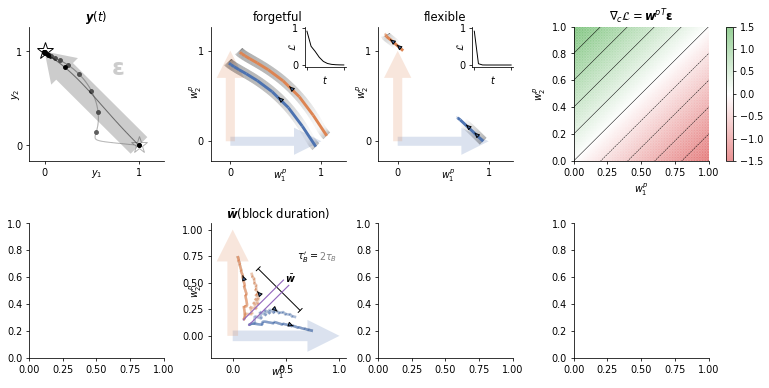

In [12]:
fig

## Limit Cycle Panels

### Simulation

In [13]:
c_tau = 1 / 50
cfg_cycle_ = dict(
    cfg_toy_ | dict(t_tot=None),
    c_tau=c_tau,
    W_tau=2.,
    num_blocks=100,
)


s_ini = .1
wbar_ini = 0.01 / 1
w1 = jnp.array([.5 + wbar_ini, .5 - wbar_ini]) / 2 * s_ini
w2 = jnp.array([.5 - wbar_ini, .5 + wbar_ini]) / 2 * s_ini
c1 = 0.5
c2 = 0.5

        
cfg_cycle = Config(**dict(cfg_cycle_, 
                      Y_tgt=get_n_phasic_curriculum(g, block_duration, *Y_tgts_flip),
                      W_teachers=Y_tgts_flip.reshape(2, 2, 1),
                      T_tape=1000),
                      )

tape_cycle = get_tape_2d(
    cfg_cycle,
    params_init_toy=dict(
        w11=w1[0],
        w12=w1[1],
        w21=w2[0],
        w22=w2[1],
        c1=c1 if s == 0 else c2,
        c2=c2 if s == 0 else c1,
                    ),
    full2toy=full2toy_6d,
    toy2full=toy2full_6d,
)



[INFO] [2024-11-21 09:47:44,768] in lcs.joint_learning: Running 1 seeds on device TFRT_CPU_0 with config Config(input_size=1,
       output_size=2,
       num_seeds=1,
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.1,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='toy',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 10.0),
                            ('L2_W', 0.0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum='A_B__',
       Y_tgt=<function get_n_phasic_curriculum.<locals>.Y_tgt at 0x16a156e60>,
       W_teachers=Array([[[0.],
        [1.]],

       [[1.],
        [0.]]], dtype=float32),
       use_X=False,
       metric='cosine,cols',
       teacher_mode='orthogonal',
       teacher_xx=0.0,
       teacher_

### Panel showing limit cycle

In [15]:
t_switches = np.where(np.abs(np.diff(tape_cycle.c_gt1) / cfg_cycle.dt_tape) > .5)[0]
print(len(t_switches))
wbar = 0.5*( (tape_cycle.w12 - tape_cycle.w11) - (tape_cycle.w22 - tape_cycle.w21))

## compute rowwise subtraction of c1
c_bar = -np.subtract.reduce(tape_cycle.c1, axis=-1)  # c2 - c1


100


In [16]:
ax = ax_limcycle
ax.cla()


plot_traj(ax, c_bar, wbar, c='black', alpha=0.2, lw=1, ls='-', mark='none', ms=ms, alpha_min=0.2, alpha_max=1.)
# make single arrow
dummy_line = ax.plot(c_bar, wbar, color='black', ls="-", alpha=0., lw=1, marker='o', ms=2)

ax.dataLim.y1 = 1.
ax.dataLim.y0 = 0.
ax.dataLim.x1 = +1.2
ax.dataLim.x0 = -1.2
ax.set_ylabel(r"$\bar w$")
ax.set_xlabel(r"$\bar c$")
ax.set_title("limit cycle")

Text(0.5, 1.0, 'limit cycle')

### Quantification of distances

In [17]:
def get_6d_diff(tape):
    W1 = tape.W1.reshape(tape.t.shape[0], -1)
    c1 = tape.c1.reshape(tape.t.shape[0], -1)

    params = jnp.concatenate([W1, c1], axis=-1)  # time x 6

    blocks = jnp.split(params, t_switches[::1])  # list of blocks
    # print(len(blocks))

    return [block for block in blocks]


params_blocks = get_6d_diff(tape_cycle)
# omit first and last block due to truncation
params_blocks = params_blocks[2:-2]
# min_length = min([block.shape[0] for block in params_blocks])
params_blocks = np.array([block[:] for block in params_blocks])

distances = [np.linalg.norm(params_blocks[i+1] - params_blocks[i], axis=-1).max() for i in range(len(params_blocks) - 1)]
# distances

In [18]:
ax = ax_convergence
ax.cla()
ax.set_title("cycle convergence")

plot_traj(ax, np.arange(len(distances)), distances, c='black', lw=1, ls='-', mark='all', ms=ms, alpha_min=0.2, alpha_max=1.)


ax.set_ylabel(r"$\langle|\boldsymbol{\theta}(t) - \boldsymbol{\theta}(t-\tau_B)|\rangle$")
ax.set_xlabel("block number")

ax.autoscale_view()

In [19]:
for ax in axd.values():
    ax.set_box_aspect(1)
    # ax.autoscale(enable=False)

    if ax not in [ax_limcycle, ax_convergence]:
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xlim(-.2, 1.3)
        ax.set_ylim(-.2, 1.3)
    # xylabel_to_ticks(ax)
    # ax.autoscale_view()


In [20]:
setup_axes_labels(axd)

### Symmetric model panel

In [21]:
tauc0s = np.logspace(-1, 0, endpoint=True, num=5)
print(tauc0s)

[0.1        0.17782794 0.31622777 0.56234133 1.        ]


In [22]:
def calc_anal_wbar(cbar, tauc0, tauw0):
    return np.sqrt((-0.25 * tauc0 + cbar**2 * tauc0 + 0.25 * tauw0) / tauw0)

In [23]:
cbar_anal = np.linspace(-0.5, 0.5, 100)

wbars_anal = []
for tauc0 in tauc0s:
    wbars_anal.append(calc_anal_wbar(cbar_anal, tauc0*0.5, 1))

## Add simulations

In [27]:
cbars = []
wbars = []
losses = []

for tauc0 in tauc0s:
    block_duration_=5
    Y_tgt = get_n_phasic_curriculum(g, block_duration_, *Y_tgts_flip)

    #c_lr = 2.
    c_lr = 1/tauc0
    W_lr = 1.
    tauc = 1/c_lr
    tauw = 1/W_lr

    cfg = Config(**dict(
        cfg_toy_ | dict(t_tot=None),  # consider setting this to None in the base config, do we really need this as a default?
        num_blocks=1,  # IMPORTANTLY, the symmetric approximation only holds within a single block
        Y_tgt=Y_tgt,
        c_tau=tauc,
        W_tau=tauw,
        W_teachers=Y_tgts_flip.reshape(2, 2, 1),
        log_aux=False,
    )
    )

    cbar = -0.5  # c1 - c0
    wbar = +0.5  # w1 - w0

    params_init = {
            'c1': 
                jnp.array((0.5-cbar, 0.5+cbar)),
            'W1':
                jnp.array([[0.5+wbar, 0.5-wbar], 
                           [0.5-wbar, 0.5+wbar]]).reshape(2, 2, 1)
        }

    tape = run_config(cfg, params_init=params_init)
    c = tape.c1[0]
    cbar = c[..., 0] - c[..., 1]
    cbars.append(cbar)

    W = tape.W1[0, ..., 0]
    Wbar = - ((W[..., 0, 0] - W[..., 0, 1]) + (W[..., 1, 1] - W[..., 1, 0]))/2

    wbars.append(Wbar)

    losses.append(tape.loss)

cbars = np.array(cbars)
wbars = np.array(wbars)
losses = np.array(losses).squeeze()

[INFO] [2024-11-21 09:52:03,014] in lcs.joint_learning: Running 1 seeds on device TFRT_CPU_0 with config Config(input_size=1,
       output_size=2,
       num_seeds=1,
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.1,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='toy',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 10.0),
                            ('L2_W', 0.0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum='A_B__',
       Y_tgt=<function get_n_phasic_curriculum.<locals>.Y_tgt at 0x3346676d0>,
       W_teachers=Array([[[0.],
        [1.]],

       [[1.],
        [0.]]], dtype=float32),
       use_X=False,
       metric='cosine,cols',
       teacher_mode='orthogonal',
       teacher_xx=0.0,
       teacher_

## Plotting

In [29]:
"""
ax = ax_symmetric
ax.cla()

# Plot the rest of the data first
for i, tauc0 in enumerate(tauc0s):
    ax.plot(cbars[i], wbars[i], label=f"$\\tau_c={tauc0:.2g}$", color=f'C{i}', linewidth=3)
    if i > 0:
        ax.plot(cbar_anal*2, wbars_anal[i]*2, linestyle='--', color='black')  # inline conversions convert from symmetric model scale to output scale

# Plot the analytical solution last
analytical_line, = ax.plot(cbar_anal*2, wbars_anal[0]*2, linestyle='--', color='black', label="analytical")

# Get the handles and labels from the current legend
handles, labels = ax.get_legend_handles_labels()

# Move the analytical solution to the first position in the legend
handles = [analytical_line] + handles[:-1]
labels = ["analytical"] + labels[:-1]

# Set the legend with the new order
ax.legend(handles, labels)

ax.set_xlim(-1, 1)
# ax.set_ylim(0, 1)
ax.set_ylim(0.65, 1)

ax.set_xlabel("cbar")
ax.set_ylabel("wbar")
"""

'\nax = ax_symmetric\nax.cla()\n\n# Plot the rest of the data first\nfor i, tauc0 in enumerate(tauc0s):\n    ax.plot(cbars[i], wbars[i], label=f"$\\tau_c={tauc0:.2g}$", color=f\'C{i}\', linewidth=3)\n    if i > 0:\n        ax.plot(cbar_anal*2, wbars_anal[i]*2, linestyle=\'--\', color=\'black\')  # inline conversions convert from symmetric model scale to output scale\n\n# Plot the analytical solution last\nanalytical_line, = ax.plot(cbar_anal*2, wbars_anal[0]*2, linestyle=\'--\', color=\'black\', label="analytical")\n\n# Get the handles and labels from the current legend\nhandles, labels = ax.get_legend_handles_labels()\n\n# Move the analytical solution to the first position in the legend\nhandles = [analytical_line] + handles[:-1]\nlabels = ["analytical"] + labels[:-1]\n\n# Set the legend with the new order\nax.legend(handles, labels)\n\nax.set_xlim(-1, 1)\n# ax.set_ylim(0, 1)\nax.set_ylim(0.65, 1)\n\nax.set_xlabel("cbar")\nax.set_ylabel("wbar")\n'

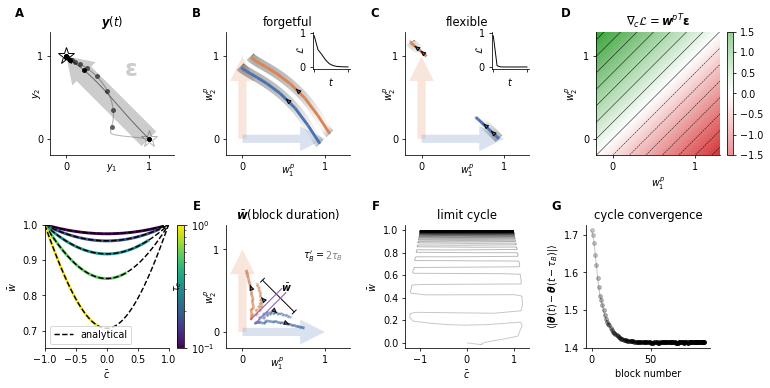

In [30]:
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

cbar = None

# Clear the current axis
ax = ax_symmetric
ax.cla()
if cbar is not None:
    cbar.remove()
    cbar = None

# Create a colormap with log scaling
norm = mcolors.LogNorm(vmin=min(tauc0s), vmax=max(tauc0s))
cmap = cm.viridis

# Plot the simulated data using a line plot with a colormap
for i, tauc0 in enumerate(tauc0s):
    color = cmap(norm(tauc0))
    ax.plot(cbars[i], wbars[i], label=f"$\\tau_c={tauc0:.2g}$", color=color, linewidth=3)
    if i > 0:
        ax.plot(cbar_anal*2, wbars_anal[i]*2, linestyle='--', color='black')  # inline conversions convert from symmetric model scale to output scale

# Plot the analytical solution last
analytical_line, = ax.plot(cbar_anal*2, wbars_anal[0]*2, linestyle='--', color='black', label="analytical")

# Get the handles and labels from the current legend
handles, labels = ax.get_legend_handles_labels()

# Move the analytical solution to the first position in the legend
handles = [analytical_line] + handles[:-1]
labels = ["analytical"] + labels[:-1]

# Create a custom colorbar with log scaling
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create a smaller colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(sm, cax=cax)

# cbar = fig.colorbar(sm, ax=ax, )
cbar.set_label(r'$\tau_c$')
xylabel_to_ticks(cbar.ax, which='y')
# label only first and last tick
ticks = cbar.get_ticks()
# no minor formatter
cbar.ax.yaxis.set_minor_formatter(plt.NullFormatter())


# Add a legend for the analytical solution
ax.legend(handles=[plt.Line2D([0], [0], linestyle='--', color='black', label='analytical')])

ax.set_xlim(-1, 1)
ax.set_ylim(0.65, 1)

ax.set_xlabel(r"$\bar c$")
ax.set_ylabel(r"$\bar w$")

fig